In [1]:
from skimage.metrics import structural_similarity as ssim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Converting to grayscale

In [12]:
import os
import cv2

def convert_images_to_grayscale():
    base_data_path = "../data"
    images_path = os.path.join(base_data_path, "images")
    videos_path = os.path.join(base_data_path, "videos")
    gray_images_path = os.path.join(base_data_path, "gray_images")

    os.makedirs(gray_images_path, exist_ok=True)

    def process_folder(source_folder, prefix):
        """ Convert all images in source_folder to grayscale and save to gray_images_path with prefix """
        for experiment in os.listdir(source_folder):
            experiment_path = os.path.join(source_folder, experiment)
            if not os.path.isdir(experiment_path):
                continue

            # Create grayscale output folder
            gray_experiment_folder = os.path.join(gray_images_path, f"{prefix}_{experiment}")
            os.makedirs(gray_experiment_folder, exist_ok=True)

            # Process each file
            for file in os.listdir(experiment_path):
                file_path = os.path.join(experiment_path, file)
                if file.endswith((".png", ".jpg", ".jpeg", ".bmp", ".ppm")):
                    img = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)
                    if img is None:
                        print(f"Skipping unreadable file: {file_path}")
                        continue  

                    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

                    output_path = os.path.join(gray_experiment_folder, file)
                    cv2.imwrite(output_path, gray_img)

    # Process both folders
    process_folder(images_path, "images")
    process_folder(videos_path, "videos")

    print("All images converted to grayscale and saved in data/gray_images.")

# Run the function
convert_images_to_grayscale()


All images converted to grayscale and saved in data/gray_images.


[ERROR:0@686.819] global loadsave.cpp:912 imwrite_ imwrite_('../data/gray_images/images_test_2/reference.ppm'): can't write data: OpenCV(4.11.0) /io/opencv/modules/imgcodecs/src/grfmt_pxm.cpp:433: error: (-5:Bad argument) Portable bitmap(.ppm) expects BGR image in function 'write'

[ERROR:0@686.830] global loadsave.cpp:912 imwrite_ imwrite_('../data/gray_images/images_test_3/reference.ppm'): can't write data: OpenCV(4.11.0) /io/opencv/modules/imgcodecs/src/grfmt_pxm.cpp:433: error: (-5:Bad argument) Portable bitmap(.ppm) expects BGR image in function 'write'

[ERROR:0@686.839] global loadsave.cpp:912 imwrite_ imwrite_('../data/gray_images/images_test_1/reference.ppm'): can't write data: OpenCV(4.11.0) /io/opencv/modules/imgcodecs/src/grfmt_pxm.cpp:433: error: (-5:Bad argument) Portable bitmap(.ppm) expects BGR image in function 'write'

[ERROR:0@686.850] global loadsave.cpp:912 imwrite_ imwrite_('../data/gray_images/videos_test_2/reference.ppm'): can't write data: OpenCV(4.11.0) /io/op

# Getting a df

In [16]:
def get_df_image_info():
    base_path = "../data/gray_images/"
    test_folders = [f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))]
    
    data = []

    for folder_name in test_folders:
        folder_path = os.path.join(base_path, folder_name)

        ref_img_path = os.path.join(folder_path, os.listdir(folder_path)[1])
        ref_img = cv2.imread(ref_img_path, cv2.IMREAD_GRAYSCALE)

        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            compare_img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

            if compare_img is not None:
                # Resize to match reference if needed
                compare_img = cv2.resize(compare_img, (ref_img.shape[1], ref_img.shape[0]))

                # Compute SSIM
                ssim_score = ssim(ref_img, compare_img)
                
                # Compute Mean Squared Error (MSE)
                mse_score = np.mean((ref_img.astype("float") - compare_img.astype("float")) ** 2)

            if os.path.exists(file_path):
                file_size = os.path.getsize(file_path) / 1024  # Convert to KB
                img = cv2.imread(file_path)
                if img is not None:
                    height, width = img.shape[:2]
                image_size = f"{width}x{height}"  # Known capture resolution
                data.append([folder_name, file, image_size, f"{file_size:.2f} KB", round(ssim_score, 4), round(mse_score, 4)])

    # Create a global DataFrame
    df = pd.DataFrame(data, columns=["Test Folder", "Format", "Resolution", "File Size", "SSIM", "MSE"])
    return df

df = get_df_image_info()
df.head(20)

,Test Folder,Format,Resolution,File Size,SSIM,MSE
0,images_test_1,output.png,352x288,38.44 KB,0.9996,0.0436
1,images_test_1,output.jpg,352x288,11.34 KB,1.0000,0.0000
2,images_test_1,output.bmp,352x288,100.05 KB,0.9996,0.0436
3,images_test_2,output.png,352x288,40.24 KB,0.9996,0.0517
4,images_test_2,output.jpg,352x288,12.90 KB,1.0000,0.0000
5,images_test_2,output.bmp,352x288,100.05 KB,0.9996,0.0517
6,images_test_3,output.png,352x288,38.44 KB,0.9996,0.0467
7,images_test_3,output.jpg,352x288,11.35 KB,1.0000,0.0000
8,images_test_3,output.bmp,352x288,100.05 KB,0.9996,0.0467
9,videos_test_1,flv.flv.jpg,640x360,20.97 KB,0.9924,1.2840


# Visualisation

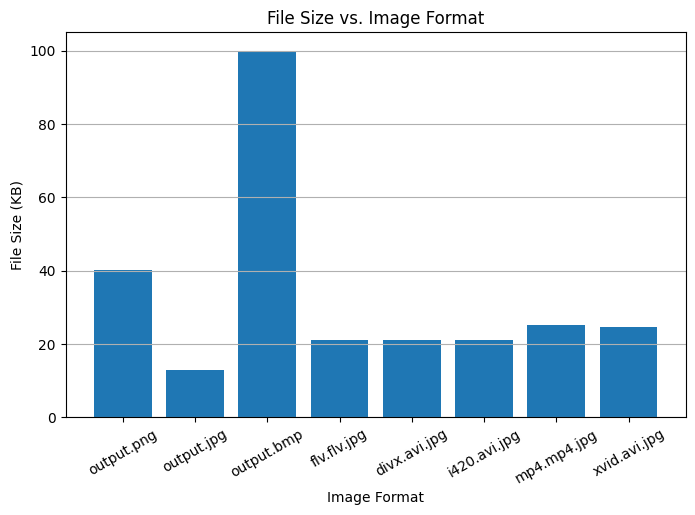

In [24]:
plt.figure(figsize=(8, 5))
plt.bar(df["Format"], df["File Size"].str.replace(" KB", "").astype(float))
plt.xlabel("Image Format")
plt.ylabel("File Size (KB)")
plt.title("File Size vs. Image Format")
plt.grid(axis="y")
plt.xticks(rotation=30)
plt.show()

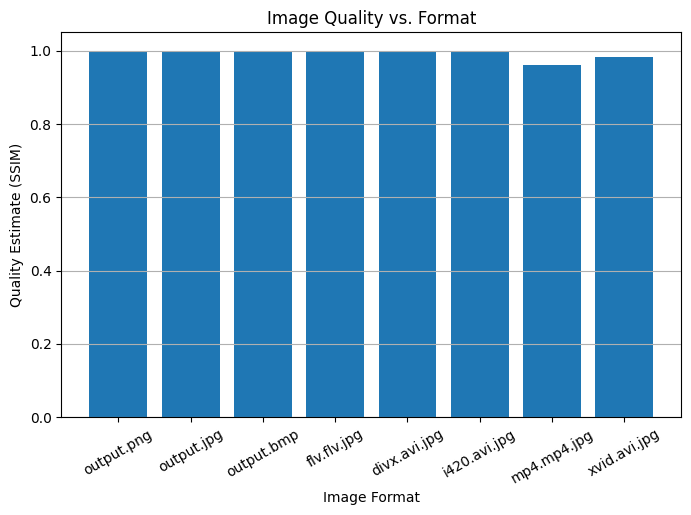

In [25]:
plt.figure(figsize=(8, 5))
plt.bar(df["Format"], df["SSIM"])
plt.xlabel("Image Format")
plt.ylabel("Quality Estimate (SSIM)")
plt.title("Image Quality vs. Format")
plt.grid(axis="y")
plt.xticks(rotation=30)
plt.show()

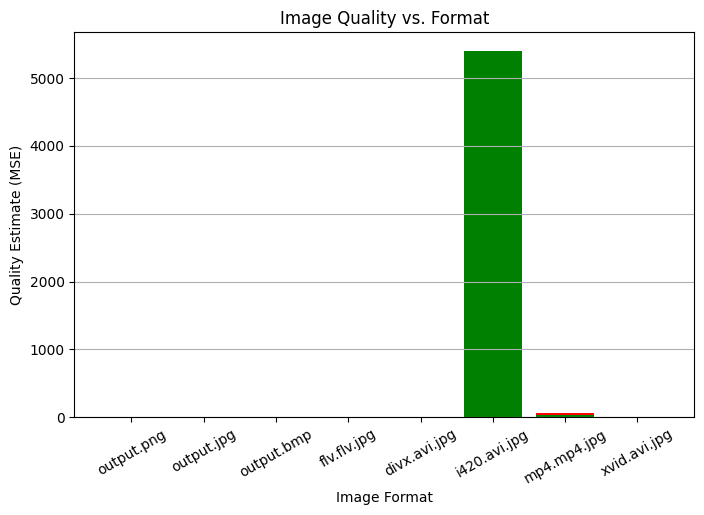

In [26]:
plt.figure(figsize=(8, 5))
plt.bar(df["Format"], df["MSE"], color=["red", "blue", "green"])
plt.xlabel("Image Format")
plt.ylabel("Quality Estimate (MSE)")
plt.title("Image Quality vs. Format")
plt.grid(axis="y")
plt.xticks(rotation=30)
plt.show()